Formulate the problem as an MDP. Clearly describe the state space, action space, reward and transition probabilities


1. State Space $\mathcal{S}$

The state space $\mathcal{S}$  in the code is defined as all possible combinations of positions of the player and the minotaur within the maze, along with two terminal states:


$\mathcal{S} = \{ ((x_1, y_1), (x_2, y_2)) \mid 0 \leq x_i \le H, 0 \leq y_i \le W, \text{ maze}[x_1, y_1] \neq 1 \} \cup \{ \text{Eaten}, \text{Win} \}$


- (x_1, y_1)  represents the player’s coordinates.
- (x_2, y_2)  represents the minotaur’s coordinates.
- W  and  L  are the width and length of the maze.
- ‘Eaten’ and ‘Win’ represent terminal states when the player is caught by the minotaur or successfully exits, respectively
- Because the minotaur can be within a wall, only the player can not, the player's x and y coordinates can not be those where the maze value equals 1. 


2. Action Space  $\mathcal{A}$ 

The action space  $\mathcal{A}$  was given in the assignment and is formalized as followed: 


$\mathcal{A} = \{ \text{stay, move left, move right, move up, move down} \}$


3. Transition Probabilities  $\mathcal{P}$

Let $P(s{\prime} \mid s, a)$ be the probability of transitioning from state $s$ to $s{\prime}$ after taking action $a$. 
The player has deterministic movement and the minotaur's moves to any valid adjacent cell, and its probability of transitioning to a new state depends on the number of possible moves. Therefore, mathematically the transition probabilities for non-terminal states is:

$P(((x{\prime}_1, y{\prime}_1), (x{\prime}_2, y{\prime}_2)) \mid ((x_1, y_1), (x_2, y_2)), a) = \frac{1}{N}$

where $N$ is the number of possible cells the minotaur can move to, and:
- $x{\prime}_1, y{\prime}_1$ are the new coordinates of the player after applying action $a$.
- $x{\prime}_2, y{\prime}_2$  are the new coordinates of the minotaur after moving randomly.

For terminal states:

$P(\text{Eaten} \mid ((x_1, y_1), (x_2, y_2)), a) = 1 \quad \text{if } (x{\prime}_1, y{\prime}_1) = (x{\prime}_2, y{\prime}_2)$

$P(\text{Win} \mid ((x_1, y_1), (x_2, y_2)), a) = 1 \quad \text{if } (\text{maze}[x{\prime}_1, y{\prime}_1] = 2)$

Once these states are reached, they  have a self-loop probability of 1, meaning:

$P(\text{Win} \mid \text{Win}, \cdot) = 1, \quad P(\text{Eaten} \mid \text{Eaten}, \cdot) = 1$

The transition probabilities assume that $\text{ maze}[x{\prime}_1, y{\prime}_1] \neq 1$ because these are not defined as possible states in $\mathcal{S}$. Furthermore, the player will not move to non-adjacent cells as these are not reachable through any actions defined within $\mathcal{A}$. 


4. Rewards $\mathcal{R}$

We want to reward the player to find the exit, therefore any action that leads to reaching this goal is prositively rewarded. Any other action does not yield any reward. However, for any action that leads to surpassing the limit of the maze a high negative reward is assigned such that this state never happens. 

Terminal rewards:
- $r(\text{Eaten}, a) = \text{MINOTAUR\_REWARD} = 0$
- $r(\text{Win}, a) = \text{GOAL\_REWARD} = 1$  

Non-terminal rewards:
- If the player attempts an invalid move (hits a wall):  
$r(s, a) = \text{IMPOSSIBLE\_REWARD} = -100$

- For valid moves that do not result in winning or being eaten:  
$r(s, a) = \text{STEP\_REWARD} = 0$

The goal is to maximize the probability of reaching the exit before getting caught by the minotaur:

$\max \mathbb{E} \left[ \sum_{t=0}^{T-1} r(s_t, a_t) + r_T(s_T) \right]$

where  $T$  is the finite time horizon, and $r_T(s_T)$ denotes the terminal reward.


## Dynamic Programming 
a) Solve the problem: find a policy that maximizes the probability of leaving the maze alive (in the shortest time possible) for T = 20. Illustrate this policy.

To find the optimal path, it is enough to set the time horizon T=15. The player needs at least 15 steps to attain the exit $B$, if the starting point is at (0,0). If ythe time horizon less than 15, no path to the exit is found. For all $T \geq 15$ the path stays the same for the same movements of the minotaur. 

To illustrate the policy please run: 

In [1]:
import numpy as np
from maze_current import Maze
from methods import dynamic_programming
from analysis import animate_solution

# Description of the maze as a numpy array
maze = np.array([
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 1, 1],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 1, 2, 0, 0]])
# With the convention 0 = empty cell, 1 = obstacle, 2 = exit of the Maze
env = Maze(maze, False)
horizon = 16

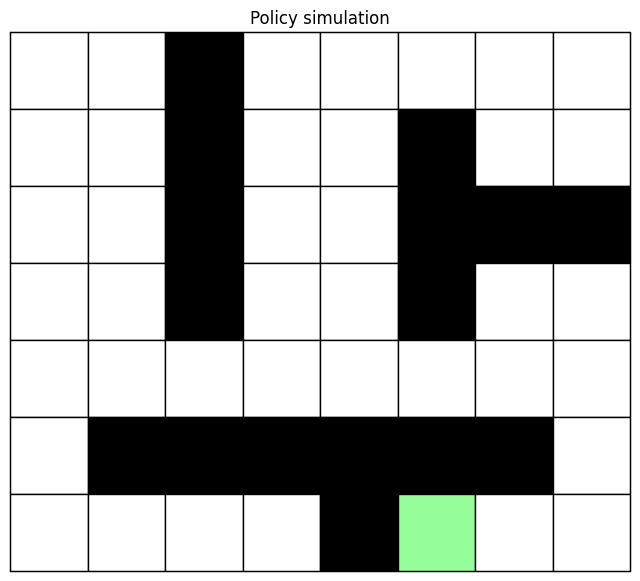

In [2]:


# Solve the MDP problem with dynamic programming
V, policy = dynamic_programming(env, horizon)  
# Simulate the shortest path starting from position A
method = 'DynProg'
start  = ((0,0), (6,5))
path = env.simulate(start, policy, method)[0]
animate_solution(maze, path)

d) For T = 1, . . . , 30 compute a policy that maximizes the probability of exiting the maze alive (in the shortest time possible) and plot the probability. Is there a difference if the minotaur is allowed to stand still? If so, why?

The optimal policy that miximizes the probability of exiting the maze alive in the shorteset time possible happens for T=15. For this time horizon the porbability of exiting the maze alive is 100\%. The below code would print this policy: 


In [3]:
from analysis import survival_rates_dynprog

def print_policy(policy, env, T):
    """
    Prints the optimal policy for each state at each time step.
    
    :param policy: The optimal policy array (S*T).
    :param env: The maze environment (for state interpretation).
    :param T: The time horizon for which the policy was computed.
    """
    print(f"Optimal policy for T={T}:")
    for t in range(T):
        print(f"Time step {t}:")
        for s in range(env.n_states):
            action = int(policy[s, t])
            if action in env.actions_names:
                state_description = env.states[s]
                print(f"  State {s} ({state_description}): {env.actions_names[action]}")
        print("\n")

exit = (6, 5)
T_range = np.array(range(13, 31))
print("Minotaur always moves:")
move_rates, policy_move = survival_rates_dynprog(maze, T_range, minotaur_stay = False)
print("Minotaur can stay: ")
try_rates, policy_stay = survival_rates_dynprog(maze, T_range, minotaur_stay = True)

Minotaur always moves:
T = 13, win 00.00%, dead 00.09%
T = 14, win 00.00%, dead 00.19%
T = 15, win 100.00%, dead 00.00%
T = 16, win 100.00%, dead 00.00%
T = 17, win 100.00%, dead 00.00%
T = 18, win 100.00%, dead 00.00%
T = 19, win 100.00%, dead 00.00%
T = 20, win 100.00%, dead 00.00%
T = 21, win 100.00%, dead 00.00%
T = 22, win 100.00%, dead 00.00%
T = 23, win 100.00%, dead 00.00%
T = 24, win 100.00%, dead 00.00%
T = 25, win 100.00%, dead 00.00%
T = 26, win 100.00%, dead 00.00%
T = 27, win 100.00%, dead 00.00%
T = 28, win 100.00%, dead 00.00%
T = 29, win 100.00%, dead 00.00%
T = 30, win 100.00%, dead 00.00%
Minotaur can stay: 
T = 13, win 00.00%, dead 00.02%
T = 14, win 00.00%, dead 00.03%
T = 15, win 28.85%, dead 02.24%
T = 16, win 44.46%, dead 02.26%
T = 17, win 53.89%, dead 02.04%
T = 18, win 61.45%, dead 01.75%
T = 19, win 67.68%, dead 01.51%
T = 20, win 72.96%, dead 01.30%
T = 21, win 77.33%, dead 01.12%
T = 22, win 80.97%, dead 00.96%
T = 23, win 83.99%, dead 00.83%
T = 24, win 8

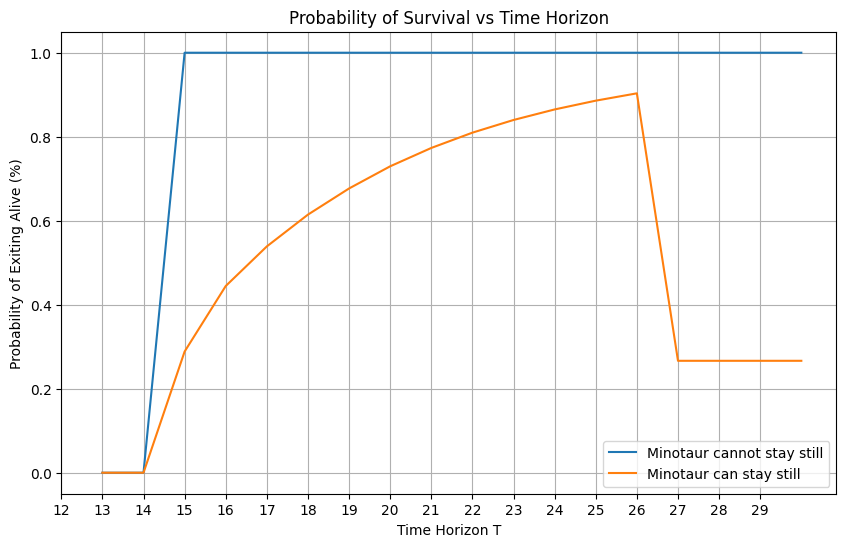

In [7]:
import matplotlib.pyplot as plt
# Plot the probabilities
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(move_rates) + 1), move_rates, label='Minotaur cannot stay still')
plt.plot(range(1, len(try_rates) + 1), try_rates, label='Minotaur can stay still')
tick_positions = range(len(move_rates))  # Positions from 0 to len(move_rates) - 1
tick_labels = range(12, 12 + len(move_rates))  # Labels starting from 15

plt.xticks(tick_positions, tick_labels)
plt.xlabel('Time Horizon T')
plt.ylabel('Probability of Exiting Alive (%)')  # Updated label to indicate percentage
plt.title('Probability of Survival vs Time Horizon')
plt.legend()
plt.grid(True)
plt.show()

# Plot of the probabilities
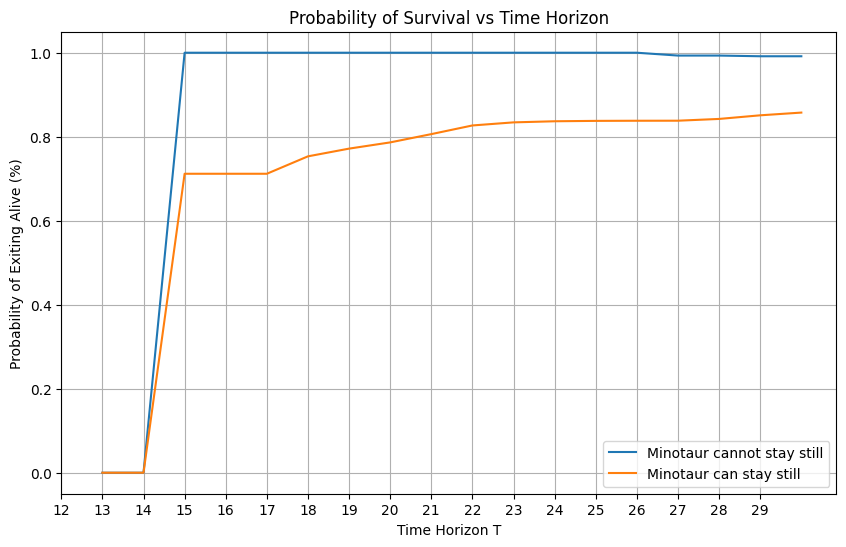


If the minotaur is not allowed to stand still it is much simpler to win for the player. The player can just move to the state the minotaur was at previously and be certain it will not be there in the next move to eat the player. When the minotaur is allowed to move this strategy does not work. 

# Value Iteration 
You are now poisoned, and need to leave the maze as soon as possible. Due to the poison, your life is geometrically distributed with mean 30. Modify the problem so as to derive a policy maximizing the probability to exit the maze. Motivate your new problem formulation.

Now we are no longer dealing with a finite time horizon as previously but an infinite one. Therefore we do not use Dynamic Programming to find the optimal policy but Value Iteration. 

As stated in the exercise we are assuming that the time is geometrically distributed with mean $\mu = 30$. The discount factor is set to $\lambda = 1 - \frac{1}{\mu}$. 

The new problem formulation is derived through finding a stationary policy that minimizes the infinite horizon objective with the discount factor stated above. 

$$
\mathbb{E} \left[ \sum_{t=0}^{\infty} \lambda^{t-1} r(s_t^{\pi},  a_t^{\pi}) \right].
$$

Through the lecture we know the Bellman equation in case of a stationary policy $\pi$ is: 

$$
\forall s \in \mathcal{S} \quad V^*(s) = \max_{\pi} \left\{ r(s, \pi(s)) + \gamma \sum_{s' \in \mathcal{S}} \mathbb{P}(s' \mid s, \pi(s)) V^*(s') \right\} \tag{2}
$$

Furthermore, through the lecture we have the VI algorithm 

1. **Initialization**. Select a value function $(V_0 \in \mathcal{V}), ( n = 0), \delta \gg 1$  
2. **Value improvement**. While $\delta > \frac{\epsilon (1 - \lambda)}{\lambda}$ do
   - (a)$( V_{n+1} = \mathcal{L}(V_n)$, i.e., for all $s \in \mathcal{S}$
     $$
     V_{n+1}(s) = \sup_{a \in \mathcal{A}_s} \left( r(s, a) + \lambda \sum_j p(j \mid s, a) V_n(j) \right)
     $$
   - (b) $\delta = \| V_{n+1} - V_n \|, n \leftarrow n + 1$

3. **Output**. $\pi = (\pi_1, \pi_2, \ldots)$ with
   $$
   \forall s \in \mathcal{S}, \quad \pi_1(s) \in \arg \max_{a \in \mathcal{A}_s} \left( r(s, a) + \lambda \sum_j p(j \mid s, a) V_n(j) \right)
   $$

And we know that VI converges since $\mathcal{L}$ is a contraction mapping. When it stops, VI returns an $\epsilon$-optimal policy
 



(f) Estimate the probability of getting out alive using this policy by simulating 10 000 games.

The probability of getting out alive with the minotaur not allowed to stay is around 55% while it is around 52% when the minotaur is allowed to stay. 

In [8]:
from analysis import survival_rate_valiter
# Can not stay: 
survival_rate_valiter(maze, mean_lifetime = 30, min_steps = 15, minotaur_stay = False)
# can stay: 
survival_rate_valiter(maze, mean_lifetime = 30, min_steps = 15, minotaur_stay = True)
  

Survived 55.380000%, compared to 60.138300% baseline
Avg. lifetime  13.3812
Survived 51.940000%, compared to 60.138300% baseline
Avg. lifetime  14.605


0.5194

## Theoretical questions: 

1) What does it mean that a learning method is on-policy or off-policy?
- On-policy learning means the method learns the value of the policy it is currently following. It explores and updates based on actions taken according to its current policy. Example: SARSA (State-Action-Reward-State-Action).  
- Off-policy learning means the method learns the value of an optimal policy independently of the policy it uses to explore. It can update its value estimates using data from a different policy. Example: Q-learning.
	
2) State the convergence conditions for Q-learning and SARSA.  

Q-learning:
- The learning rate $\alpha_t$ should decay over time such that $\sum_{t=1}^{\infty} \alpha_t = \infty$ and $\sum_{t=1}^{\infty} \alpha_t^2 < \infty$  (e.g., $\alpha_t = \frac{1}{t}$).
- The agent must visit all state-action pairs infinitely often.   

SARSA:
- Same learning rate condition as Q-learning ($\alpha_t$ decays appropriately).
- The agent should explore sufficiently (e.g., use an $\epsilon$-greedy policy to ensure all actions are tried).
- $\epsilon \rightarrow 0$ as $t \rightarrow \inf$ 

### Maze with keys
The introduction of new transition probabilities and keys requires modification of the state space, rewards, and transition probabilities. 

Because the life of the player is still geometrically distributed, "poised", we need to model the MDP as a discounted MDP. The discount factor is set to $\lambda = 1 - \frac{1}{\mu}$ with $\mu = 50$. 

We define a new state space $\mathcal{S_h}$: 
The state space is similar to the one previously defined with the additional constraint if the player has or has not the key. We define $\mathcal{S}$ as the state space from the beginning. 

$\mathcal{S_h} = \{((x_1, y_1), (x_2, y_2), k) \mid ((x_1, y_1), (x_2, y_2)) \in \mathcal{S}, \text{ k}\in \{1,0\}\} \cup \{ \text{Eaten}, \text{Win} \}$

where k = 1 indicates the player is in posession of the key and k=0 means he is not. 
Because all keys are in position C and we assume that once the player has one key they have all keys, we only define k=1 or k=0 (has all or has no key). 

Next we need to define the new transition probabilities $\mathcal{P_h}$: 

With probability 0.35 the minotaur moves towards the player. Defining these actions gives: 

- Minotaur is in the same row as the player: the minotaur moves along the x-direction towards the player
- Minotaur is in the same column as the player: the minotaur moves along the y-direction towards the player. 
- Minotaur is neither in the same row nor column: the minotaur can move along the x- or y-direction towards the player. 

With probability 0.65 the minotaur takes any OTHER valid action as defined previously. 

Furthermore, we need to adapt the transition probability for exiting the game, e.g. winning the game.   
If k = 0 $(\text{maze}[x{\prime}_1, y{\prime}_1] = 2)$ does not mean the player wins, therefore it does no longer hold:   
$P(\text{Win} \mid ((x_1, y_1), (x_2, y_2)), a) = 1 \quad \text{if } (\text{maze}[x{\prime}_1, y{\prime}_1] = 2)$

We adapt the rewards $\mathcal{R_h}$ to include a reward for grabing the key by adding 
  
$r(s, a) = \text{KEY\_REWARD} = 1$ to $\mathcal{R}$. 



# Bonus


i) Compute a policy that solves problem (h). Implement the episodic Q-learning algorithm using an ε-greedy policy. Note that you should not reset the Q-values between one episode and the other (remember to update the Q-values in each round!)

Class QLearning:
    Initialize:
        Input: environment (env), epsilon, discount (gamma), alpha, q_init
        Initialize Q-table (Q[state][action]) with q_init or 0 for terminal states
        Initialize action counts (_n) to zeros
        Set exploration (epsilon) and learning rate parameters (alpha)

    Function q(state, action):
        Return Q[state][action]

    Function v(state):
        Return max(Q[state])  # Maximum Q-value over all actions

    Function compute_action(state, explore=True):
        Get valid actions for the state
        If explore AND random(epsilon):
            Return random valid action
        Else:
            Return action with max Q-value for the state (break ties randomly)

    Function update(last_experience):
        Extract state, action, reward, next_state from last_experience
        Compute step_size = 1 / (count(state, action) ** alpha)
        Update Q[state][action] using the Bellman equation:
            Q[state][action] += step_size * (reward + gamma * max(Q[next_state]) - Q[state][action])
        Increment count(state, action)

    Function train(n_episodes):
        Initialize statistics for tracking rewards, lengths, and initial state values
        For each episode:
            Reset environment to the initial state
            While episode is not done:
                Select an action using compute_action()
                Perform the action, observe reward, next_state, and done
                Record the experience
                Update Q-values using update()
                Accumulate reward and increment episode length
                Transition to next_state
            Log statistics (reward, length, initial state value)
        Return statistics and initial state value progression

In [9]:
NUM_EPISODES = 5000
INITIAL_STATE = ((0, 0), (6, 5), "NOKEYS")
maze = np.array([
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 1, 1],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 1, 2, 0, 0]])

# Initialize the environment
expected_life = 50 
gamma = 1- (1/expected_life)

The plot below highlights the impact of $\epsilon$ on Q-learning performance and policy success. For $\epsilon = 0.1$, the agent achieves a moderate balance between exploration and exploitation, resulting in the highest exit probability (0.48) and relatively stable average rewards and lengths. When ￼$\epsilon = 0.01$, the agent prioritizes exploitation more aggressively, leading to slightly lower exit probability (0.33) but longer episode lengths (28.8), indicating it focuses more on refining an optimal policy. Conversely, with $\epsilon = 1$, the agent is fully exploratory, achieving no meaningful rewards or policy success (exit probability = 0.0), as it fails to converge to a useful strategy within the episode limit. These results demonstrate that excessive exploration hinders learning, while moderate exploration offers the best trade-off for convergence and performance.

Episode 5000 - Reward: 0.0 - Length: 3 - Avg reward: 1.0 - Avg length: 26.6: 100%|██████████| 5000/5000 [00:06<00:00, 777.25it/s]  


Exit_probability for epsilon 0.1:  0.48


Episode 5000 - Reward: 2.0 - Length: 38 - Avg reward: 1.0 - Avg length: 28.8: 100%|██████████| 5000/5000 [00:06<00:00, 793.87it/s] 


Exit_probability for epsilon 0.01 0.33


Episode 5000 - Reward: 0.0 - Length: 38 - Avg reward: 0.0 - Avg length: 25.3: 100%|██████████| 5000/5000 [00:05<00:00, 929.14it/s]  


Exit_probability for epsilon 1:  0.0


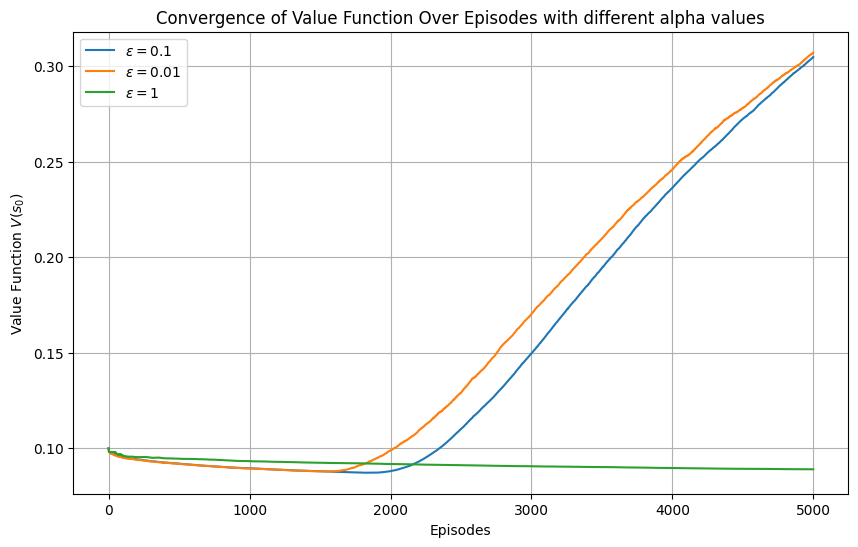

In [ ]:
# test different epsilon values, keep alpha fixed
from q_agent import QLearning
from bonus import minotaur_maze_exit_probability, Maze
epsilon1 = 0.1
alpha1 = (2/3)
env1 = Maze(maze, seed= 6, expected_life=expected_life, minotaur_chase=True, keys=True)
agent_q_learning = QLearning(
        env=env1,
        discount=gamma,
        alpha= alpha1,
        epsilon=epsilon1,
        q_init=0.1,
    )
_, values_epsilon1 = agent_q_learning.train(NUM_EPISODES)
exit_probability = minotaur_maze_exit_probability(env1, agent_q_learning)
print(f"Exit_probability for epsilon {epsilon1}: ", exit_probability)
epsilon2 = 0.01
env2 = Maze(maze, seed= 6, expected_life=expected_life, minotaur_chase=True, keys=True)
agent_q_learning = QLearning(
        env=env2,
        discount=gamma,
        alpha= alpha1,
        epsilon=epsilon2,
        q_init=0.1,
    )
_, values_epsilon2 = agent_q_learning.train(NUM_EPISODES)
exit_probability = minotaur_maze_exit_probability(env2, agent_q_learning)
print(f"Exit_probability for epsilon {epsilon2}:", exit_probability)

epsilon3 = 1
env3 = Maze(maze, seed= 6, expected_life=expected_life, minotaur_chase=True, keys=True)
agent_q_learning = QLearning(
        env=env3,
        discount=gamma,
        alpha= alpha1,
        epsilon=epsilon3,
        q_init=0.1,
    )
_, values_epsilon3 = agent_q_learning.train(NUM_EPISODES)
exit_probability = minotaur_maze_exit_probability(env2, agent_q_learning)
print(f"Exit_probability for epsilon {epsilon3}: ", exit_probability)
plt.figure(figsize=(10, 6))
plt.plot(range(NUM_EPISODES), values_epsilon1, label=f"$\\epsilon = {epsilon1}$")
plt.plot(range(NUM_EPISODES), values_epsilon2, label=f"$\\epsilon = {epsilon2}$")
plt.plot(range(NUM_EPISODES), values_epsilon3, label=f"$\\epsilon = {epsilon3}$")
plt.xlabel("Episodes")
plt.ylabel(f"Value Function $V(s_0)$")
plt.title("Convergence of Value Function Over Episodes with different epsilon values")
plt.legend()
plt.grid()
plt.show()

Test different initialization for convergence speed, use best epsilon from above tests, 0.1.
The resulting graph illustrates that different initial Q-values influence the convergence speed of the value function $V(s_0)$ over episodes. When Q-values are initialized optimistically (e.g., $q\_init = 1$), the algorithm initially overestimates the values, resulting in faster exploration but a slower decline before stabilizing. Conversely, lower initial Q-values (e.g., $q\_init = 0.01$) lead to more cautious updates, with slower convergence but more stable growth. 

Episode 5000 - Reward: 0.0 - Length: 3 - Avg reward: 1.0 - Avg length: 26.6: 100%|██████████| 5000/5000 [00:06<00:00, 719.98it/s]  


Exit_probability for init value 0.1:  0.48


Episode 5000 - Reward: 0.0 - Length: 14 - Avg reward: 0.9 - Avg length: 27.1: 100%|██████████| 5000/5000 [00:06<00:00, 737.51it/s] 


Exit_probability for init value 0.01: 0.44


Episode 5000 - Reward: 1.0 - Length: 32 - Avg reward: 0.8 - Avg length: 33.8: 100%|██████████| 5000/5000 [00:06<00:00, 759.22it/s] 


Exit_probability for init value 1:  0.21


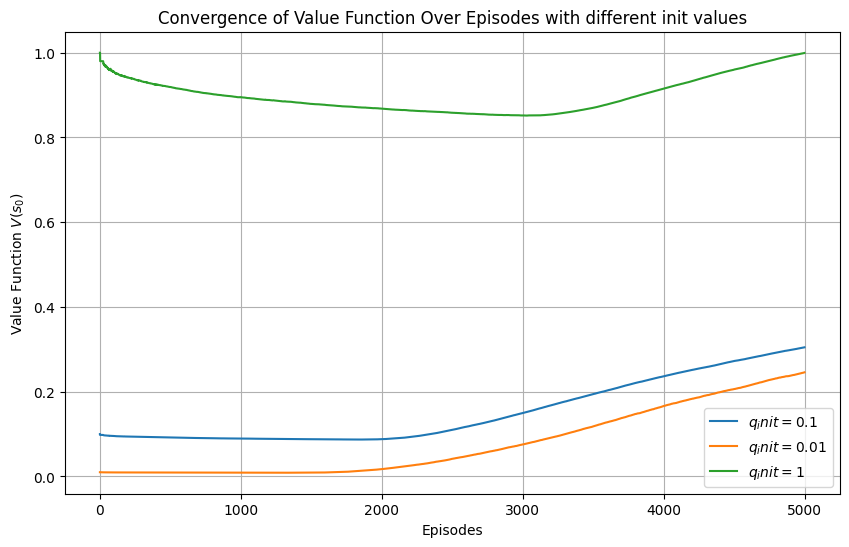

In [ ]:
# test different epsilon values, keep alpha fixed
epsilon = 0.1
q_init1 = 0.1
alpha1 = (2/3)
env1 = Maze(maze, seed= 6, expected_life=expected_life, minotaur_chase=True, keys=True)
agent_q_learning = QLearning(
        env=env1,
        discount=gamma,
        alpha= alpha1,
        epsilon=epsilon,
        q_init=q_init1,
    )
_, values_epsilon1 = agent_q_learning.train(NUM_EPISODES)
exit_probability = minotaur_maze_exit_probability(env1, agent_q_learning)
print(f"Exit_probability for init value {q_init1}: ", exit_probability)
q_init2 = 0.01
env2 = Maze(maze, seed= 6, expected_life=expected_life, minotaur_chase=True, keys=True)
agent_q_learning = QLearning(
        env=env2,
        discount=gamma,
        alpha=alpha1,
        epsilon=epsilon,
        q_init=q_init2,
    )
_, values_epsilon2 = agent_q_learning.train(NUM_EPISODES)
exit_probability = minotaur_maze_exit_probability(env2, agent_q_learning)
print(f"Exit_probability for init value {q_init2}:", exit_probability)

q_init3 = 1
env3 = Maze(maze, seed= 6, expected_life=expected_life, minotaur_chase=True, keys=True)
agent_q_learning = QLearning(
        env=env3,
        discount=gamma,
        alpha= alpha1,
        epsilon=epsilon,
        q_init=q_init3,
    )
_, values_epsilon3 = agent_q_learning.train(NUM_EPISODES)
exit_probability = minotaur_maze_exit_probability(env3, agent_q_learning)
print(f"Exit_probability for init value {q_init3}: ", exit_probability)
plt.figure(figsize=(10, 6))
plt.plot(range(NUM_EPISODES), values_epsilon1, label=f"$q-init = {epsilon1}$")
plt.plot(range(NUM_EPISODES), values_epsilon2, label=f"$q-init = {epsilon2}$")
plt.plot(range(NUM_EPISODES), values_epsilon3, label=f"$q-init = {epsilon3}$")
plt.xlabel("Episodes")
plt.ylabel(f"Value Function $V(s_0)$")
plt.title("Convergence of Value Function Over Episodes with different init values")
plt.legend()
plt.grid()
plt.show()

The plot below visualizes that the choice of $\alpha$ significantly impacts the convergence speed and performance of Q-learning. For $\alpha = 1.0$: The value function remains flat at 0 throughout the episodes, indicating that the Q-values of $s_0$ are not being updated effectively. Despite the flat trajectory of $V(s_0)$ for $\alpha = 1$, the exit probability is non-zero ($0.4$). This discrepancy suggests that some learning and successful trajectories occur, but they are not reflected in the initial state’s value $V(s_0)$. An explanation for this is that for $\alpha = 1$, the step size becomes constant ($1 / n^{\alpha}$ is always 1), making the Q-values entirely dependent on the most recent reward and future estimates. The constant learning rate prevents Q-values from stabilizing over time, making convergence slower or nonexistent, especially for states like $s_0$ that require multiple updates to reflect accurate values. 

$\alpha = 0.55 $ shows a steep and consistent growth of $V(s_0)$ after around 2000 episodes. The overall slower decay of the step size, compared to $\alpha = 0.77$ allows for continued learning and refinement of the policy, which results in higher convergence and better overall performance in terms of maximizing the value function. While the faster decay of the step size with $\alpha = 0.77$ limits the agent’s ability to make significant updates to Q-values as training progresses it might be preferable in scenarios where faster stabilization of Q-values is required.

Episode 5000 - Reward: 0.0 - Length: 6 - Avg reward: 0.9 - Avg length: 25.4: 100%|██████████| 5000/5000 [00:10<00:00, 456.37it/s]  


Exit_probability for alpha value 0.55:  0.51


Episode 5000 - Reward: 1.0 - Length: 22 - Avg reward: 1.0 - Avg length: 34.7: 100%|██████████| 5000/5000 [00:11<00:00, 449.62it/s] 


Exit_probability for alpha value 1: 0.37


Episode 5000 - Reward: 1.0 - Length: 27 - Avg reward: 1.2 - Avg length: 28.8: 100%|██████████| 5000/5000 [00:11<00:00, 445.66it/s] 


Exit_probability for alpha value 0.77:  0.53


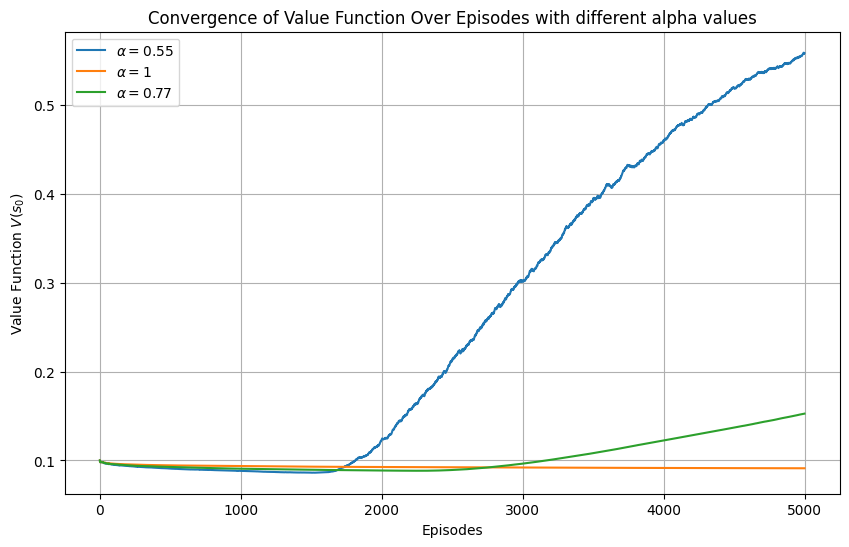

In [17]:
# test different epsilon values, keep alpha fixed
epsilon = 0.1
q_init1 = 0.1
alpha1 = (0.55)
env1 = Maze(maze, seed= 6, expected_life=expected_life, minotaur_chase=True, keys=True)
agent_q_learning = QLearning(
        env=env1,
        discount=gamma,
        alpha= alpha1,
        epsilon=epsilon,
        q_init=q_init1,
    )
_, values_epsilon1 = agent_q_learning.train(NUM_EPISODES)
exit_probability = minotaur_maze_exit_probability(env1, agent_q_learning)
print(f"Exit_probability for alpha value {alpha1}: ", exit_probability)
alpha2 = 1
env2 = Maze(maze, seed= 6, expected_life=expected_life, minotaur_chase=True, keys=True)
agent_q_learning = QLearning(
        env=env2,
        discount=gamma,
        alpha=alpha2,
        epsilon=epsilon,
        q_init=q_init1,
    )
_, values_epsilon2 = agent_q_learning.train(NUM_EPISODES)
exit_probability = minotaur_maze_exit_probability(env2, agent_q_learning)
print(f"Exit_probability for alpha value {alpha2}:", exit_probability)

alpha3 = 0.77
env3 = Maze(maze, seed= 6, expected_life=expected_life, minotaur_chase=True, keys=True)
agent_q_learning = QLearning(
        env=env3,
        discount=gamma,
        alpha= alpha3,
        epsilon=epsilon,
        q_init=q_init1,
    )
_, values_epsilon3 = agent_q_learning.train(NUM_EPISODES)
exit_probability = minotaur_maze_exit_probability(env3, agent_q_learning)
print(f"Exit_probability for alpha value {alpha3}: ", exit_probability)
plt.figure(figsize=(10, 6))
plt.plot(range(NUM_EPISODES), values_epsilon1, label=f"$\\alpha = {alpha1}$")
plt.plot(range(NUM_EPISODES), values_epsilon2, label=f"$\\alpha = {alpha2}$")
plt.plot(range(NUM_EPISODES), values_epsilon3, label=f"$\\alpha = {alpha3}$")
plt.xlabel("Episodes")
plt.ylabel(f"Value Function $V(s_0)$")
plt.title("Convergence of Value Function Over Episodes with different alpha values")
plt.legend()
plt.grid()
plt.show()

j) The only difference to the implementation of q-learning function is the update function. We are still trying to solve the same problem (first finding the key, being poised, having a minotaur chaising us with probability 35%, needing to find the exit withe the keys), thus the logic of iteration is the same just how the q-function is updated differs. We no longer multiply the discount by the difference between the estimated optimal future value and the current Q-value for a given state-action pair but we update the q-values based on the action chosen by the current policy. 

Episode 5000 - Reward: 1.0 - Length: 54 - Avg reward: 0.8 - Avg length: 37.2: 100%|██████████| 5000/5000 [00:13<00:00, 375.69it/s] 


Exit_probability for SARSA agent:  0.2


Episode 5000 - Reward: 1.0 - Length: 38 - Avg reward: 0.5 - Avg length: 42.8: 100%|██████████| 5000/5000 [00:13<00:00, 383.10it/s] 


Exit_probability for SARSA agent:  0.07


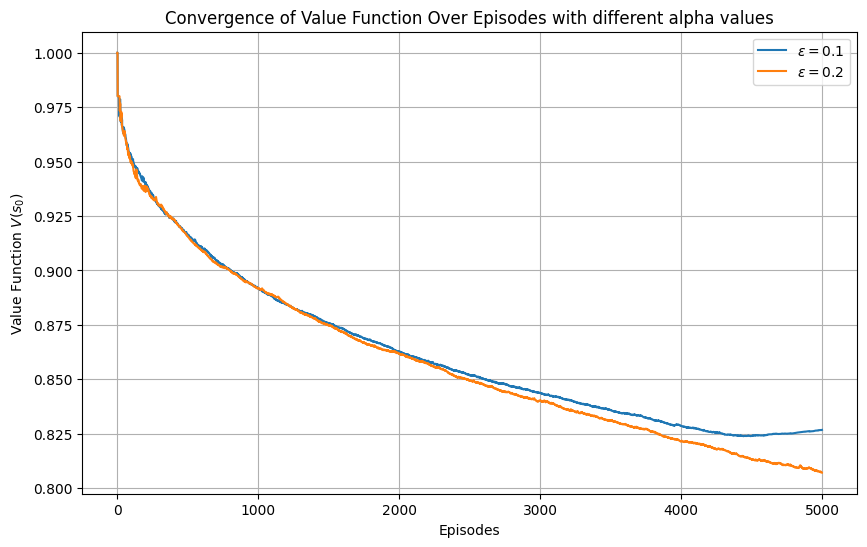

In [18]:
from sarsa_agent import SARSA
epsilon1 = 0.1
alpha = (2/3)
env1 = Maze(maze, seed= 6, expected_life=expected_life, minotaur_chase=True, keys=True)
agent_sarsa = SARSA(
        env=env1,
        discount=gamma,
        alpha=alpha,
        epsilon=epsilon1,
        q_init=1,
    )
_, values_epsilon1 = agent_sarsa.train(NUM_EPISODES)
exit_probability = minotaur_maze_exit_probability(env1, agent_sarsa)
print(f"Exit_probability for SARSA agent: ", exit_probability)
epsilon2 = 0.2
env2 = Maze(maze, seed= 6, expected_life=expected_life, minotaur_chase=True, keys=True)
agent_sarsa = SARSA(
        env=env2,
        discount=gamma,
        alpha=alpha,
        epsilon=epsilon2,
        q_init=1,
    )
_, values_epsilon2 = agent_sarsa.train(NUM_EPISODES)
exit_probability = minotaur_maze_exit_probability(env2, agent_sarsa)
print(f"Exit_probability for SARSA agent: ", exit_probability)

plt.figure(figsize=(10, 6))
plt.plot(range(NUM_EPISODES), values_epsilon1, label=f"$\\epsilon = {epsilon1}$")
plt.plot(range(NUM_EPISODES), values_epsilon2, label=f"$\\epsilon = {epsilon2}$")
plt.xlabel("Episodes")
plt.ylabel(f"Value Function $V(s_0)$")
plt.title("Convergence of Value Function Over Episodes with different alpha values")
plt.legend()
plt.grid()
plt.show()